Nowe podejście - połączenie oversamplingu oraz undersamplingu. Przy samym undersamplingu tracimy wiele danych, a przy samym oversamplingu łatwo o duplikację danych, powielanie i brak różnorodności w piosenkach. Tutaj badamy, jak modele zachowają się przy zastosowaniu takiego kompromisu.

In [1]:
import kagglehub
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import librosa
from collections import Counter
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, mean_squared_error, mean_absolute_error, r2_score

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
path = kagglehub.dataset_download("imsparsh/deam-mediaeval-dataset-emotional-analysis-in-music")
print(path)
static_annotations_file = static_csv = os.path.join(path, 'DEAM_Annotations', 'annotations',
                          'annotations averaged per song', 'song_level',
                          'static_annotations_averaged_songs_1_2000.csv')
audio_path = os.path.join(path, 'DEAM_audio', 'MEMD_audio',)

C:\Users\Gabi\.cache\kagglehub\datasets\imsparsh\deam-mediaeval-dataset-emotional-analysis-in-music\versions\1


In [3]:
df = pd.read_csv(static_annotations_file)
df

,song_id,valence_mean,valence_std,arousal_mean,arousal_std
0,2,3.1,0.94,3.0,0.63
1,3,3.5,1.75,3.3,1.62
2,4,5.7,1.42,5.5,1.63
3,5,4.4,2.01,5.3,1.85
4,7,5.8,1.47,6.4,1.69
...,...,...,...,...,...
1739,1996,3.9,1.87,5.9,2.21
1740,1997,5.3,1.42,3.9,1.14
1741,1998,6.4,1.50,6.2,1.60
1742,1999,4.6,2.11,5.4,1.80


In [4]:
conditions = [
    (df[' valence_mean'] >= 5) & (df[' arousal_mean'] >= 5),
    (df[' valence_mean'] >= 5) & (df[' arousal_mean'] <= 5),
    (df[' valence_mean'] <= 5) & (df[' arousal_mean'] <= 5),
    (df[' valence_mean'] <= 5) & (df[' arousal_mean'] >= 5)
]
choices = ['happy', 'relaxed', 'sad', 'anger']
df_4 = df.copy(deep=True)
df_4['emotion'] = np.select(conditions, choices, default=None)
first = df_4.pop('emotion')
df_4.insert(4, 'emotion', first)
df_4

,song_id,valence_mean,valence_std,arousal_mean,emotion,arousal_std
0,2,3.1,0.94,3.0,sad,0.63
1,3,3.5,1.75,3.3,sad,1.62
2,4,5.7,1.42,5.5,happy,1.63
3,5,4.4,2.01,5.3,anger,1.85
4,7,5.8,1.47,6.4,happy,1.69
...,...,...,...,...,...,...
1739,1996,3.9,1.87,5.9,anger,2.21
1740,1997,5.3,1.42,3.9,relaxed,1.14
1741,1998,6.4,1.50,6.2,happy,1.60
1742,1999,4.6,2.11,5.4,anger,1.80


In [5]:
def classify_emotion(valence, arousal):
    if valence >= 5 and arousal >= 5:
        return 'happy'
    if valence >= 5 and arousal <= 5:
        return 'relaxed'
    if valence <= 5 and arousal <= 5:
        return 'sad'
    if valence <= 5 and arousal >= 5:
        return 'anger'

Oprócz zmiany częstotliwości oraz dodania szumu, stosujemy tym razem też zmiany czasu.

In [6]:
def augment_audio(segment, sr, number):
    # Time Stretch
    # rate = random.uniform(0.8, 1.2)
    # stretched = librosa.effects.time_stretch(y=segment, rate=rate)
    # if len(stretched) >= len(segment):
    #     stretched = stretched[:len(segment)]
    # else:
    #     stretched = np.pad(stretched, (0, len(segment) - len(stretched)))
    # augmented.append(stretched)

    if number % 3 == 0:
        # Pitch Shift
        return librosa.effects.pitch_shift(segment, sr=sr, n_steps=random.choice([-2, 2]))

    elif number % 3 == 1:
        # Add noise
        return segment + 0.005 * np.random.randn(len(segment))

    else:
        # Time Shift
        shift = int(0.1 * sr)
        return np.roll(segment, shift)

In [7]:
X = []
y = []
y_reg = []

h, s, r, a = 0, 0, 0, 0
for x, song_id in enumerate(df['song_id']):
    print(f"{x} / {len(df)}")
    emotion = df_4[df_4['song_id'] == song_id]['emotion'].iloc[0]
    emotion_reg = df[df['song_id'] == song_id][[' valence_mean', ' arousal_mean']].values[0]

    y_audio, sr = librosa.load(f"{audio_path}/{song_id}.mp3", sr=44100, mono=True)

    segment_length = 10
    segment_samples = segment_length * sr

    h_i, s_i = 0, 0
    for i in range(0, len(y_audio) - segment_samples, segment_samples):
        segment = y_audio[i:i + segment_samples]

        # Oryginalny segment
        mel_spec = librosa.feature.melspectrogram(y=segment, sr=sr, n_mels=128)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
        X.append(mel_spec_db)
        y.append(emotion)
        y_reg.append(emotion_reg)

        if emotion == 'anger':
            aug = augment_audio(segment, sr, a)
            mel_spec = librosa.feature.melspectrogram(y=aug, sr=sr, n_mels=128)
            mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
            X.append(mel_spec_db)
            y.append(emotion)
            y_reg.append(emotion_reg)
            a += 1
            if a % 5 == 0:
                aug = augment_audio(segment, sr, a)
                mel_spec = librosa.feature.melspectrogram(y=aug, sr=sr, n_mels=128)
                mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
                X.append(mel_spec_db)
                y.append(emotion)
                y_reg.append(emotion_reg)
                a += 1
        elif emotion == 'relaxed':
            aug = augment_audio(segment, sr, r)
            mel_spec = librosa.feature.melspectrogram(y=aug, sr=sr, n_mels=128)
            mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
            X.append(mel_spec_db)
            y.append(emotion)
            y_reg.append(emotion_reg)
            r += 1
        elif emotion == 'happy':
            h += 1
            h_i += 1
            if h_i >= 3 or (h > 1200 and h_i >= 2):
                break
        elif emotion == 'sad':
            s += 1
            s_i += 1
            if s_i >= 3 or (s > 900 and s_i >= 2):
                break

0 / 1744
1 / 1744
2 / 1744
3 / 1744
4 / 1744
5 / 1744
6 / 1744
7 / 1744
8 / 1744
9 / 1744
10 / 1744
11 / 1744
12 / 1744
13 / 1744
14 / 1744
15 / 1744
16 / 1744
17 / 1744
18 / 1744
19 / 1744
20 / 1744
21 / 1744
22 / 1744
23 / 1744
24 / 1744
25 / 1744
26 / 1744
27 / 1744
28 / 1744
29 / 1744
30 / 1744
31 / 1744
32 / 1744
33 / 1744
34 / 1744
35 / 1744
36 / 1744
37 / 1744
38 / 1744
39 / 1744
40 / 1744
41 / 1744
42 / 1744
43 / 1744
44 / 1744
45 / 1744
46 / 1744
47 / 1744
48 / 1744
49 / 1744
50 / 1744
51 / 1744
52 / 1744
53 / 1744
54 / 1744
55 / 1744
56 / 1744
57 / 1744
58 / 1744
59 / 1744
60 / 1744
61 / 1744
62 / 1744
63 / 1744
64 / 1744
65 / 1744
66 / 1744
67 / 1744
68 / 1744
69 / 1744
70 / 1744
71 / 1744
72 / 1744
73 / 1744
74 / 1744
75 / 1744
76 / 1744
77 / 1744
78 / 1744
79 / 1744
80 / 1744
81 / 1744
82 / 1744
83 / 1744
84 / 1744
85 / 1744
86 / 1744
87 / 1744
88 / 1744
89 / 1744
90 / 1744
91 / 1744
92 / 1744
93 / 1744
94 / 1744
95 / 1744
96 / 1744
97 / 1744
98 / 1744
99 / 1744
100 / 1744

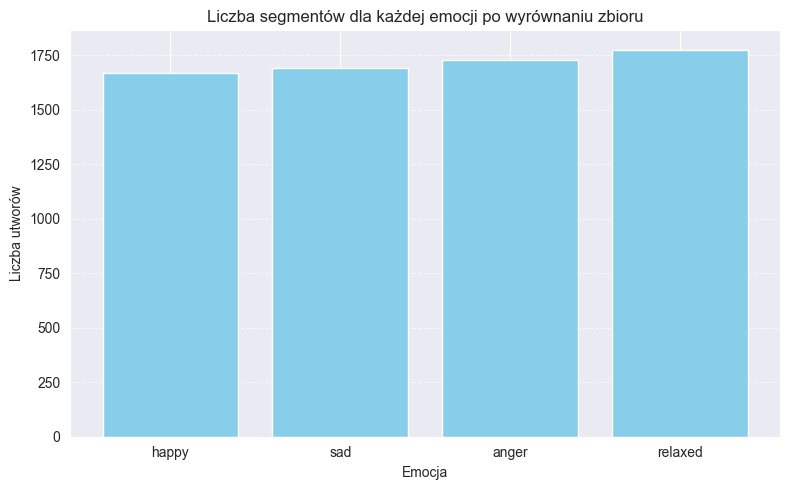

In [8]:
emotion_amount = {
    'happy': 0,
    'sad': 0,
    'anger': 0,
    'relaxed': 0
}
for emotion in y:
    if emotion == 'happy':
        emotion_amount['happy'] += 1
    elif emotion == 'sad':
        emotion_amount['sad'] += 1
    elif emotion == 'anger':
        emotion_amount['anger'] += 1
    elif emotion == 'relaxed':
        emotion_amount['relaxed'] += 1

labels = list(emotion_amount.keys())
values = list(emotion_amount.values())

plt.figure(figsize=(8, 5))
plt.bar(labels, values, color='skyblue')
plt.title('Liczba segmentów dla każdej emocji po wyrównaniu zbioru')
plt.xlabel('Emocja')
plt.ylabel('Liczba utworów')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
X_1 = np.array([feat.astype(np.float32).flatten() for feat in X], dtype=np.float32)
print(X_1.shape)

In [9]:
y = np.array(y)
print(y.shape)

(6863,)


In [11]:
le = LabelEncoder()
y_en = le.fit_transform(y)

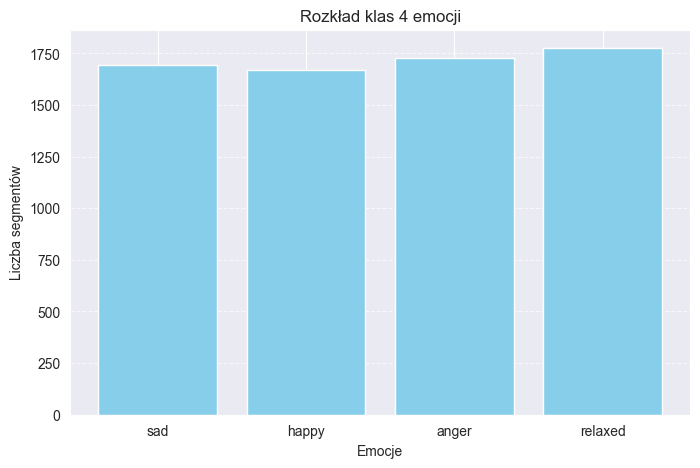

In [12]:
label_counts = Counter(y)
labels = list(label_counts.keys())
counts = list(label_counts.values())

plt.figure(figsize=(8, 5))
plt.bar(labels, counts, color='skyblue')
plt.title('Rozkład klas 4 emocji')
plt.xlabel('Emocje')
plt.ylabel('Liczba segmentów')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [19]:
X_train, X_test, y_train, y_test = train_test_split(
    X_1,
    y_en,
    test_size=0.2,
    random_state=42,
    stratify=y_en)

Accuracy jest odrobinę niższe niż przy samym oversamplingu, jednak macierz konfuzji wskazuje, że model w podobnym stopniu rozpoznaje wszystkie emocje - klasyfikacja jest równomierna, żadna emocja nie przeważa, większy procent jest w rozpoznanych dobrze emocjach niż poza.

Accuracy:  0.5636896046852123
              precision    recall  f1-score   support

       anger       0.62      0.41      0.49       345
       happy       0.53      0.68      0.59       327
     relaxed       0.54      0.47      0.50       355
         sad       0.59      0.71      0.64       339

    accuracy                           0.56      1366
   macro avg       0.57      0.57      0.56      1366
weighted avg       0.57      0.56      0.56      1366



[Text(0, 0.5, 'anger'),
 Text(0, 1.5, 'happy'),
 Text(0, 2.5, 'relaxed'),
 Text(0, 3.5, 'sad')]

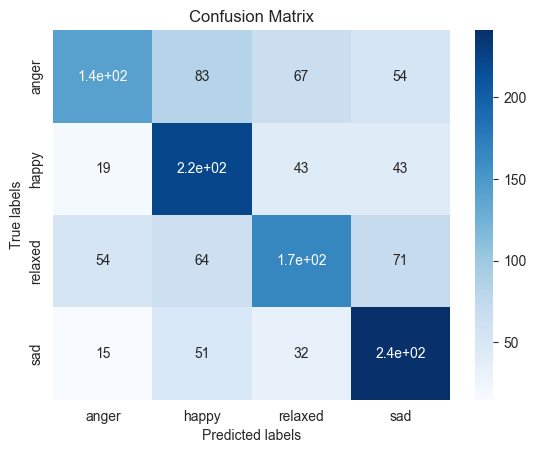

In [20]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print("Accuracy: ", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=le.classes_))

confusion_matrix = confusion_matrix(y_test, y_pred)
ax = plt.subplot()
sns.heatmap(confusion_matrix, annot=True, cmap='Blues')
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(le.classes_)
ax.yaxis.set_ticklabels(le.classes_)

Sieć CNN

Normalizacja danych w komentarzu nie przyniosła oczekiwanych rezultatów, wyniki się nie poprawiły, więc używamy czystych danych X.

In [13]:
X_cnn = np.array(X, dtype=np.float32)
X_cnn = np.expand_dims(X_cnn, axis=-1)

# X_cnn_mean = (X_cnn - X_cnn.mean(axis=(1, 2, 3), keepdims=True)) / (X_cnn.std(axis=(1, 2, 3), keepdims=True) + 1e-6)
# print(X_cnn_mean.shape)

y_cnn = to_categorical(y_en)
print(y_cnn.shape)

(6863, 4)


In [14]:
X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn = train_test_split(X_cnn, y_cnn, test_size=0.2, random_state=42, stratify=y_en)

In [14]:
input_shape = X_train_cnn.shape[1:]
num_classes = y_train_cnn.shape[1]

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D(2, 2),
    BatchNormalization(),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    BatchNormalization(),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    BatchNormalization(),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

C:\Users\Gabi\PycharmProjects\Music-Emotion-Recognition\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 860, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 430, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 63, 430, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 428, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 214, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 30, 214, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 212, 128)   │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 106, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 14, 106, 128)   │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 189952)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    48,627,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 48,722,564 (185.86 MB)

 Trainable params: 48,722,116 (185.86 MB)

 Non-trainable params: 448 (1.75 KB)

In [15]:
history = model.fit(
    X_train_cnn, y_train_cnn,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[EarlyStopping(patience=5),
               ModelCheckpoint("over_under_class_cnn_model.keras",
                save_best_only=True)]
)

Epoch 1/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 322s 2s/step - accuracy: 0.3021 - loss: 17.5404 - val_accuracy: 0.2332 - val_loss: 16.0306
Epoch 2/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 282s 2s/step - accuracy: 0.2988 - loss: 1.4320 - val_accuracy: 0.2678 - val_loss: 1.5131
Epoch 3/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 267s 2s/step - accuracy: 0.2610 - loss: 1.4172 - val_accuracy: 0.2705 - val_loss: 1.4098
Epoch 4/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 337s 2s/step - accuracy: 0.2642 - loss: 1.3867 - val_accuracy: 0.3051 - val_loss: 1.3702
Epoch 5/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 277s 2s/step - accuracy: 0.2820 - loss: 1.3852 - val_accuracy: 0.2678 - val_loss: 1.4177
Epoch 6/50
  8/138 ━━━━━━━━━━━━━━━━━━━━ 4:30 2s/step - accuracy: 0.2311 - loss: 1.3857


KeyboardInterrupt



In [40]:
model = tf.keras.models.load_model("over_under_class_cnn_model.keras")

Sieć ponownie nie radzi sobie z tego rodzaju danymi

43/43 ━━━━━━━━━━━━━━━━━━━━ 24s 475ms/step
Accuracy:  0.2578295702840495
              precision    recall  f1-score   support

       anger       0.00      0.00      0.00       346
       happy       0.00      0.00      0.00       334
     relaxed       0.26      1.00      0.41       355
         sad       0.00      0.00      0.00       338

    accuracy                           0.26      1373
   macro avg       0.06      0.25      0.10      1373
weighted avg       0.07      0.26      0.11      1373



C:\Users\Gabi\PycharmProjects\Music-Emotion-Recognition\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Gabi\PycharmProjects\Music-Emotion-Recognition\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Gabi\PycharmProjects\Music-Emotion-Recognition\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

[Text(0, 0.5, 'anger'),
 Text(0, 1.5, 'happy'),
 Text(0, 2.5, 'relaxed'),
 Text(0, 3.5, 'sad')]

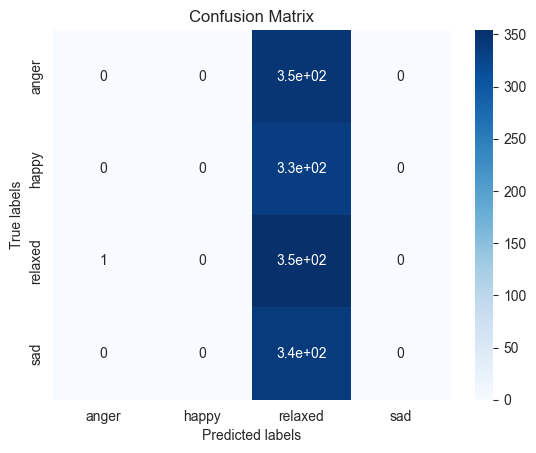

In [41]:
y_pred = model.predict(X_test_cnn)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test_cnn, axis=1)

print("Accuracy: ", accuracy_score(y_true_labels, y_pred_labels))
print(classification_report(y_true_labels, y_pred_labels, target_names=le.classes_))

confusion_matrix = confusion_matrix(y_true_labels, y_pred_labels)
ax = plt.subplot()
sns.heatmap(confusion_matrix, annot=True, cmap='Blues')
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(le.classes_)
ax.yaxis.set_ticklabels(le.classes_)

Regresja

In [17]:
y_reg = np.array(y_reg)
X_train_reg_cnn, X_test_reg_cnn, y_train_reg_cnn, y_test_reg_cnn = train_test_split(X_cnn, y_reg, test_size=0.2, random_state=42)

In [18]:
scaler = MinMaxScaler(feature_range=(0, 1))

y_train_2d = y_train_reg_cnn.reshape(-1, 2)
y_test_2d = y_test_reg_cnn.reshape(-1, 2)
scaler.fit(y_train_2d)

y_train_reg_cnn = scaler.transform(y_train_2d).reshape(y_train_reg_cnn.shape)
y_test_reg_cnn = scaler.transform(y_test_2d).reshape(y_test_reg_cnn.shape)

In [19]:
model_reg = models.Sequential([
    layers.Input(shape=X_train_reg_cnn.shape[1:]),

    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),

    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),

    layers.Dense(2, activation='linear')
])

model_reg.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

In [20]:
history_reg = model_reg.fit(X_train_reg_cnn, y_train_reg_cnn,
                    validation_split=0.2,
                    epochs=50, batch_size=32,
                    callbacks=[EarlyStopping(patience=5),
                               ModelCheckpoint("over_under_reg_cnn_model.keras",
                                save_best_only=True)]
                    )

Epoch 1/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 170s 1s/step - loss: 30227.1094 - mae: 38.0112 - val_loss: 0.0697 - val_mae: 0.2086
Epoch 2/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 181s 1s/step - loss: 0.0815 - mae: 0.2271 - val_loss: 0.0792 - val_mae: 0.2161
Epoch 3/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 182s 1s/step - loss: 0.0556 - mae: 0.1870 - val_loss: 0.0390 - val_mae: 0.1599
Epoch 4/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 177s 1s/step - loss: 0.0421 - mae: 0.1622 - val_loss: 0.0329 - val_mae: 0.1441
Epoch 5/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 225s 2s/step - loss: 0.0373 - mae: 0.1543 - val_loss: 0.0303 - val_mae: 0.1409
Epoch 6/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 239s 2s/step - loss: 0.0340 - mae: 0.1477 - val_loss: 0.0316 - val_mae: 0.1442
Epoch 7/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 226s 2s/step - loss: 0.0343 - mae: 0.1481 - val_loss: 0.0295 - val_mae: 0.1380
Epoch 8/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 216s 2s/step - loss: 0.0316 - mae: 0.1409 - val_loss: 0.0301 - val_mae: 0.1389
Epoch 9/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 231

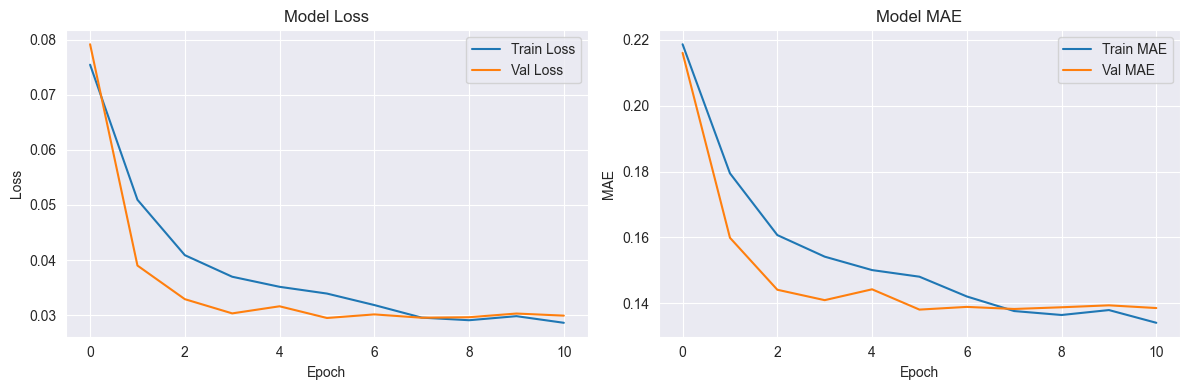

In [21]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_reg.history['loss'][1:], label='Train Loss')
plt.plot(history_reg.history['val_loss'][1:], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_reg.history['mae'][1:], label='Train MAE')
plt.plot(history_reg.history['val_mae'][1:], label='Val MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

In [22]:
y_pred = model_reg.predict(X_test_reg_cnn)

43/43 ━━━━━━━━━━━━━━━━━━━━ 14s 314ms/step


In [23]:
def evaluate_model(y_test, y_pred):
    mse_valence = mean_squared_error(y_pred[:, 0], y_test[:, 0])
    mse_arousal = mean_squared_error(y_pred[:, 1], y_test[:, 1])
    print("REGRESSION ERRORS")
    print("-------------------------------------")
    print(f"MSE Valence: {mse_valence:.4f}")
    print(f"MSE Arousal: {mse_arousal:.4f}")
    print("-------------------------------------")

    mae_valence = mean_absolute_error(y_pred[:, 0], y_test[:, 0])
    mae_arousal = mean_absolute_error(y_pred[:, 1], y_test[:, 1])
    print(f"MAE Valence: {mae_valence:.4f}")
    print(f"MAE Arousal: {mae_arousal:.4f}")
    print("-------------------------------------")

    r2_valence = r2_score(y_pred[:, 0], y_test[:, 0])
    r2_arousal = r2_score(y_pred[:, 1], y_test[:, 1])
    print(f"R² Valence: {r2_valence:.4f}")
    print(f"R² Arousal: {r2_arousal:.4f}")
    print("-------------------------------------")

    print("CLASSIFICATION ACCURACY\n")

    classification_pred = []
    classification_true = []
    for i in range(len(y_test)):
        pred = scaler.inverse_transform([y_pred[i]])[0]
        valence_pred = pred[0]
        arousal_pred = pred[1]

        test = scaler.inverse_transform([y_test[i]])[0]
        valence_test = test[0]
        arousal_test = test[1]

        classification_pred.append(classify_emotion(valence_pred, arousal_pred))
        classification_true.append(classify_emotion(valence_test, arousal_test))

    print("Accuracy:", accuracy_score(classification_true, classification_pred))
    print(classification_report(classification_true, classification_pred))

    conusion_matrix = confusion_matrix(classification_true, classification_pred)
    ax = plt.subplot()
    sns.heatmap(conusion_matrix, annot=True, cmap='Blues')
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(np.unique(classification_true))
    ax.yaxis.set_ticklabels(np.unique(classification_true))

Wyniki klasyfikacji są słabe, mimo że błąd regresji jest niski - najprawdopodobniej z powodu użycia statycznych adnotacji, średnich na cały utwór, są one wykorzystywane dla każdej sekwencji. Na przyszłość trzeba by zastosować adnotacje dynamiczne i obliczyć średnie adnotacje dla każdego okna.

REGRESSION ERRORS
-------------------------------------
MSE Valence: 0.0252
MSE Arousal: 0.0327
-------------------------------------
MAE Valence: 0.1270
MAE Arousal: 0.1458
-------------------------------------
R² Valence: -1.7493
R² Arousal: -1.6921
-------------------------------------
CLASSIFICATION ACCURACY

Accuracy: 0.36125273124544793
              precision    recall  f1-score   support

       anger       0.32      0.17      0.22       346
       happy       0.38      0.41      0.40       314
     relaxed       0.41      0.17      0.24       364
         sad       0.35      0.70      0.47       349

    accuracy                           0.36      1373
   macro avg       0.36      0.36      0.33      1373
weighted avg       0.36      0.36      0.33      1373



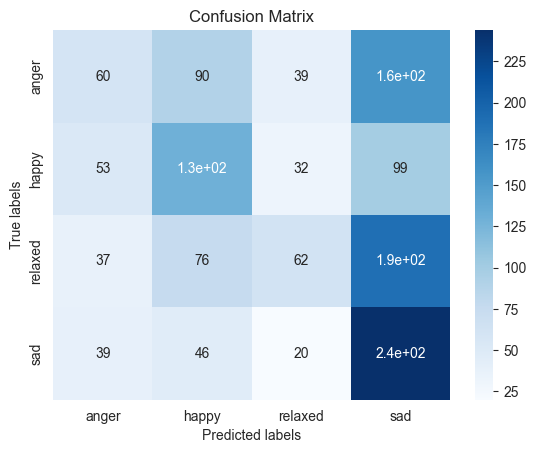

In [24]:
evaluate_model(y_test_reg_cnn, y_pred)

In [29]:
print("EVALUATION OF ONE SONG (SEQUENCE)\n")
probe_number = 3

true = scaler.inverse_transform([y_test_reg_cnn[probe_number]])[0]
valence_true = true[0]
arousal_true = true[1]
emotion_true = classify_emotion(valence_true, arousal_true)

pred = scaler.inverse_transform([y_pred[probe_number]])[0]
valence_pred = pred[0]
arousal_pred = pred[1]
emotion_pred = classify_emotion(valence_pred, arousal_pred)

print(f"Results for probe no {probe_number}:")
print(f"True emotion: {emotion_true}")
print(f"True valence: {valence_true:.4f}, true arousal: {arousal_true:.4f}")
print(f"Predicted emotion: {emotion_pred}")
print(f"Predicted valence: {valence_pred:.4f}, predicted arousal: {arousal_pred:.4f}")

EVALUATION OF ONE SONG (SEQUENCE)

Results for probe no 3:
True emotion: relaxed
True valence: 5.8000, true arousal: 4.6000
Predicted emotion: anger
Predicted valence: 4.9304, predicted arousal: 5.1536


Uczenie transferowe - wybrany model ResNet50

In [14]:
import cv2

X_rgb = []
for mel in X:
    mel_norm = cv2.normalize(mel, None, 0, 255, cv2.NORM_MINMAX)
    mel_uint8 = mel_norm.astype(np.uint8)

    mel_resized = cv2.resize(mel_uint8, (224, 224))
    mel_rgb = cv2.cvtColor(mel_resized, cv2.COLOR_GRAY2RGB)
    X_rgb.append(mel_rgb)

X_rgb = np.array(X_rgb)

In [15]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input

X_rgb = preprocess_input(X_rgb)
y_cnn = to_categorical(y_en)

X_train, X_test, y_train, y_test = train_test_split(X_rgb, y_cnn, stratify=y_en, test_size=0.2, random_state=42)
base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))

In [34]:
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
output = Dense(y_train.shape[1], activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 10s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,850,500 (90.98 MB)

 Trainable params: 262,788 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [35]:
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=30,
    batch_size=32,
    callbacks=[
        EarlyStopping(patience=5, restore_best_weights=True),
        ModelCheckpoint("best_transfer_model.keras", save_best_only=True)
    ]
)

Epoch 1/30


C:\Users\Gabi\PycharmProjects\Music-Emotion-Recognition\venv\lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_11']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


138/138 ━━━━━━━━━━━━━━━━━━━━ 262s 2s/step - accuracy: 0.3883 - loss: 1.4246 - val_accuracy: 0.4973 - val_loss: 1.1070
Epoch 2/30
138/138 ━━━━━━━━━━━━━━━━━━━━ 248s 2s/step - accuracy: 0.5044 - loss: 1.1192 - val_accuracy: 0.5291 - val_loss: 1.0635
Epoch 3/30
138/138 ━━━━━━━━━━━━━━━━━━━━ 257s 2s/step - accuracy: 0.5133 - loss: 1.0785 - val_accuracy: 0.5519 - val_loss: 1.0158
Epoch 4/30
138/138 ━━━━━━━━━━━━━━━━━━━━ 270s 2s/step - accuracy: 0.5574 - loss: 1.0473 - val_accuracy: 0.5729 - val_loss: 1.0048
Epoch 5/30
138/138 ━━━━━━━━━━━━━━━━━━━━ 268s 2s/step - accuracy: 0.5604 - loss: 1.0202 - val_accuracy: 0.6020 - val_loss: 0.9551
Epoch 6/30
138/138 ━━━━━━━━━━━━━━━━━━━━ 269s 2s/step - accuracy: 0.5693 - loss: 0.9931 - val_accuracy: 0.6138 - val_loss: 0.9423
Epoch 7/30
138/138 ━━━━━━━━━━━━━━━━━━━━ 246s 2s/step - accuracy: 0.5922 - loss: 0.9712 - val_accuracy: 0.6184 - val_loss: 0.9180
Epoch 8/30
138/138 ━━━━━━━━━━━━━━━━━━━━ 235s 2s/step - accuracy: 0.6029 - loss: 0.9511 - val_accuracy: 0.626

Loss oraz accuracy w trakcie uczenia wypadają bardzo dobrze - nie wystąpiło przeuczenie. Accuracy jest na poziomie 72%, najwyższe jak do tej pory, też emocje są równomiernie rozpoznawane, żadna nie dominuje.

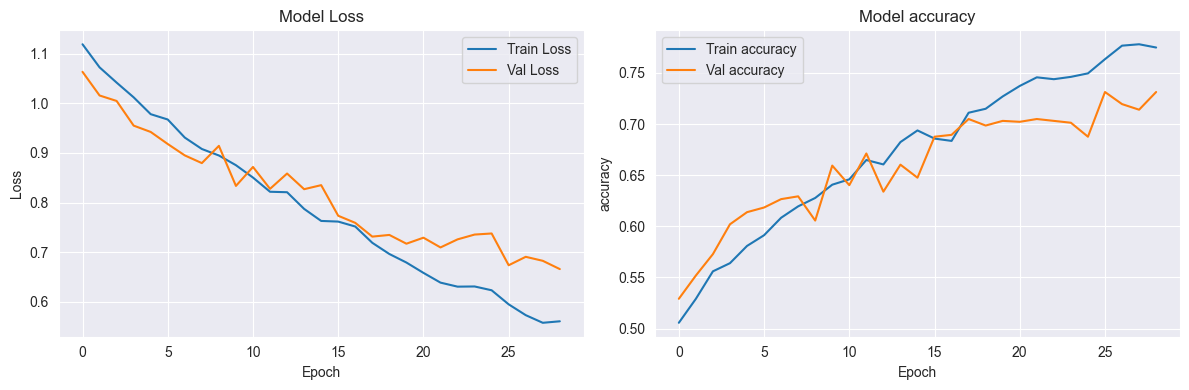

In [36]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'][1:], label='Train Loss')
plt.plot(history.history['val_loss'][1:], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'][1:], label='Train accuracy')
plt.plot(history.history['val_accuracy'][1:], label='Val accuracy')
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend()

plt.tight_layout()
plt.show()

C:\Users\Gabi\PycharmProjects\Music-Emotion-Recognition\venv\lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_11']
Received: inputs=Tensor(shape=(32, 224, 224, 3))
  warnings.warn(msg)


42/43 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step

C:\Users\Gabi\PycharmProjects\Music-Emotion-Recognition\venv\lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_11']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


43/43 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step
Accuracy:  0.7254187909686817
              precision    recall  f1-score   support

       anger       0.77      0.65      0.71       346
       happy       0.66      0.81      0.73       334
     relaxed       0.74      0.70      0.72       355
         sad       0.76      0.74      0.75       338

    accuracy                           0.73      1373
   macro avg       0.73      0.73      0.73      1373
weighted avg       0.73      0.73      0.72      1373



[Text(0, 0.5, 'anger'),
 Text(0, 1.5, 'happy'),
 Text(0, 2.5, 'relaxed'),
 Text(0, 3.5, 'sad')]

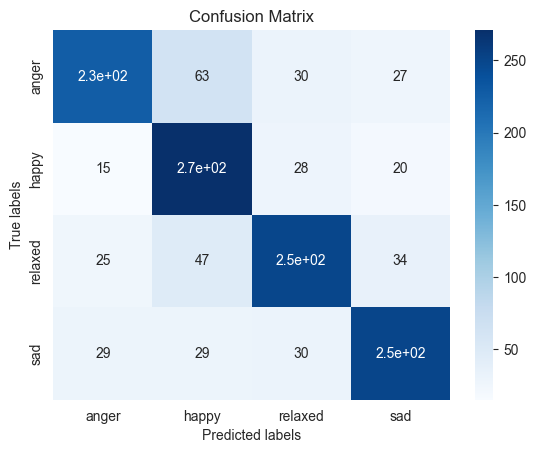

In [37]:
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

print("Accuracy: ", accuracy_score(y_true_labels, y_pred_labels))
print(classification_report(y_true_labels, y_pred_labels, target_names=le.classes_))

confusion_matrix = confusion_matrix(y_true_labels, y_pred_labels)
ax = plt.subplot()
sns.heatmap(confusion_matrix, annot=True, cmap='Blues')
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(le.classes_)
ax.yaxis.set_ticklabels(le.classes_)

In [41]:
model = tf.keras.models.load_model("best_transfer_model.keras")

Finetuning modelu - nie przyniósł on lepszych wyników, bo model się przeuczył, a accuracy i tak nie wiele się podniosło.

In [44]:
# Odmrażamy ostatnie 30 warstw
for layer in base_model.layers[-30:]:
    layer.trainable = True

# Kompilujemy ponownie z niższym learning rate
model.compile(optimizer=Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

In [45]:
history_finetune = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=15,
    batch_size=32,
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)]
)

Epoch 1/15
138/138 ━━━━━━━━━━━━━━━━━━━━ 358s 3s/step - accuracy: 0.7875 - loss: 0.5401 - val_accuracy: 0.7377 - val_loss: 0.6517
Epoch 2/15
138/138 ━━━━━━━━━━━━━━━━━━━━ 294s 2s/step - accuracy: 0.7952 - loss: 0.5348 - val_accuracy: 0.7413 - val_loss: 0.6417
Epoch 3/15
138/138 ━━━━━━━━━━━━━━━━━━━━ 315s 2s/step - accuracy: 0.7911 - loss: 0.5151 - val_accuracy: 0.7413 - val_loss: 0.6361
Epoch 4/15
138/138 ━━━━━━━━━━━━━━━━━━━━ 293s 2s/step - accuracy: 0.8218 - loss: 0.4871 - val_accuracy: 0.7441 - val_loss: 0.6317
Epoch 5/15
138/138 ━━━━━━━━━━━━━━━━━━━━ 322s 2s/step - accuracy: 0.7949 - loss: 0.5123 - val_accuracy: 0.7459 - val_loss: 0.6291
Epoch 6/15
138/138 ━━━━━━━━━━━━━━━━━━━━ 326s 2s/step - accuracy: 0.8124 - loss: 0.4829 - val_accuracy: 0.7459 - val_loss: 0.6269
Epoch 7/15
138/138 ━━━━━━━━━━━━━━━━━━━━ 322s 2s/step - accuracy: 0.8273 - loss: 0.4765 - val_accuracy: 0.7450 - val_loss: 0.6251
Epoch 8/15
138/138 ━━━━━━━━━━━━━━━━━━━━ 308s 2s/step - accuracy: 0.8097 - loss: 0.4923 - val_accu

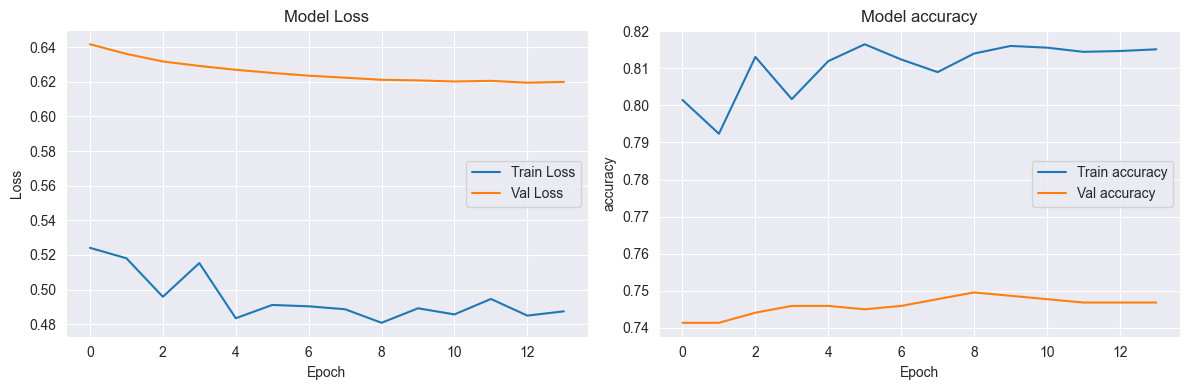

In [48]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_finetune.history['loss'][1:], label='Train Loss')
plt.plot(history_finetune.history['val_loss'][1:], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_finetune.history['accuracy'][1:], label='Train accuracy')
plt.plot(history_finetune.history['val_accuracy'][1:], label='Val accuracy')
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend()

plt.tight_layout()
plt.show()

43/43 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step
Accuracy:  0.7385287691187181
              precision    recall  f1-score   support

       anger       0.77      0.72      0.74       346
       happy       0.69      0.78      0.73       334
     relaxed       0.75      0.70      0.73       355
         sad       0.75      0.76      0.75       338

    accuracy                           0.74      1373
   macro avg       0.74      0.74      0.74      1373
weighted avg       0.74      0.74      0.74      1373



[Text(0, 0.5, 'anger'),
 Text(0, 1.5, 'happy'),
 Text(0, 2.5, 'relaxed'),
 Text(0, 3.5, 'sad')]

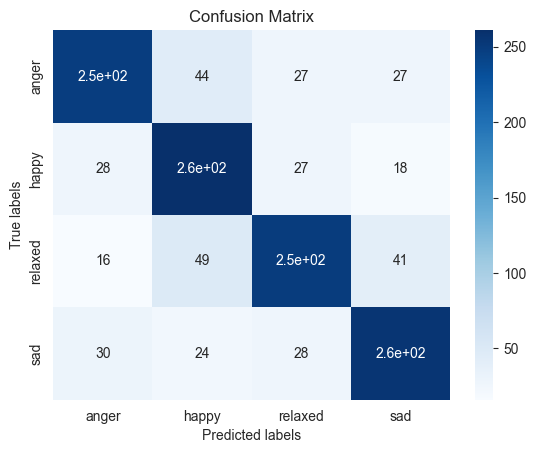

In [49]:
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

print("Accuracy: ", accuracy_score(y_true_labels, y_pred_labels))
print(classification_report(y_true_labels, y_pred_labels, target_names=le.classes_))

confusion_matrix = confusion_matrix(y_true_labels, y_pred_labels)
ax = plt.subplot()
sns.heatmap(confusion_matrix, annot=True, cmap='Blues')
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(le.classes_)
ax.yaxis.set_ticklabels(le.classes_)

To samo uczenie transferowe, ale z dodatkową augmentacją danych (już samych obrazów spectrogramów) za pomocą ImageDataGen.

In [16]:
base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
output = Dense(y_train.shape[1], activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,850,500 (90.98 MB)

 Trainable params: 262,788 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [18]:
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=False,  # spektrogramów się nie odwraca poziomo
    fill_mode='nearest'
)

datagen.fit(X_train)
history_augmented = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_test, y_test),
    epochs=40,
    callbacks=[
        EarlyStopping(patience=5, restore_best_weights=True),
        ModelCheckpoint("best_transfer_model_augmented.keras", save_best_only=True)
    ]
)

C:\Users\Gabi\PycharmProjects\Music-Emotion-Recognition\venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40
172/172 ━━━━━━━━━━━━━━━━━━━━ 329s 2s/step - accuracy: 0.4541 - loss: 1.1896 - val_accuracy: 0.5120 - val_loss: 1.1115
Epoch 2/40
172/172 ━━━━━━━━━━━━━━━━━━━━ 424s 2s/step - accuracy: 0.4826 - loss: 1.1498 - val_accuracy: 0.4938 - val_loss: 1.1120
Epoch 3/40
172/172 ━━━━━━━━━━━━━━━━━━━━ 406s 2s/step - accuracy: 0.5040 - loss: 1.1223 - val_accuracy: 0.5171 - val_loss: 1.0705
Epoch 4/40
172/172 ━━━━━━━━━━━━━━━━━━━━ 390s 2s/step - accuracy: 0.5114 - loss: 1.1001 - val_accuracy: 0.5120 - val_loss: 1.0747
Epoch 5/40
172/172 ━━━━━━━━━━━━━━━━━━━━ 339s 2s/step - accuracy: 0.5128 - loss: 1.0984 - val_accuracy: 0.5229 - val_loss: 1.0633
Epoch 6/40
172/172 ━━━━━━━━━━━━━━━━━━━━ 359s 2s/step - accuracy: 0.5190 - loss: 1.0854 - val_accuracy: 0.5317 - val_loss: 1.0630
Epoch 7/40
172/172 ━━━━━━━━━━━━━━━━━━━━ 361s 2s/step - accuracy: 0.5390 - loss: 1.0723 - val_accuracy: 0.5659 - val_loss: 1.0155
Epoch 8/40
172/172 ━━━━━━━━━━━━━━━━━━━━ 380s 2s/step - accuracy: 0.5430 - loss: 1.0447 - val_accu

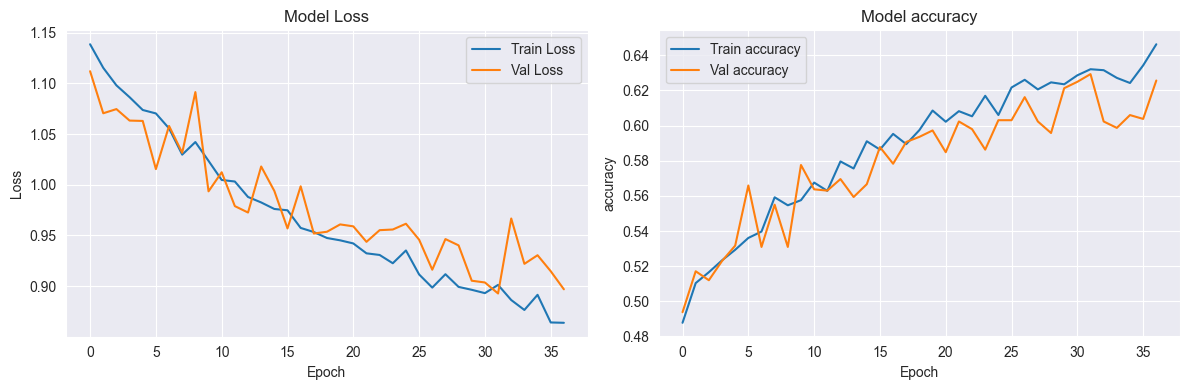

In [19]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_augmented.history['loss'][1:], label='Train Loss')
plt.plot(history_augmented.history['val_loss'][1:], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_augmented.history['accuracy'][1:], label='Train accuracy')
plt.plot(history_augmented.history['val_accuracy'][1:], label='Val accuracy')
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Po augmentacji danych za pomocą ImageDataGen loss oraz accuracy podczas uczenia prezentują się dobrze, jednak ostateczne accuracy jest niższe (62%) niż przy modelu bez augmentacji obrazów.

C:\Users\Gabi\PycharmProjects\Music-Emotion-Recognition\venv\lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_175']
Received: inputs=Tensor(shape=(32, 224, 224, 3))
  warnings.warn(msg)


42/43 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step

C:\Users\Gabi\PycharmProjects\Music-Emotion-Recognition\venv\lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_175']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


43/43 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step
Accuracy:  0.629278951201748
              precision    recall  f1-score   support

       anger       0.67      0.49      0.57       346
       happy       0.56      0.83      0.67       334
     relaxed       0.61      0.58      0.60       355
         sad       0.74      0.62      0.67       338

    accuracy                           0.63      1373
   macro avg       0.64      0.63      0.63      1373
weighted avg       0.64      0.63      0.63      1373



[Text(0, 0.5, 'anger'),
 Text(0, 1.5, 'happy'),
 Text(0, 2.5, 'relaxed'),
 Text(0, 3.5, 'sad')]

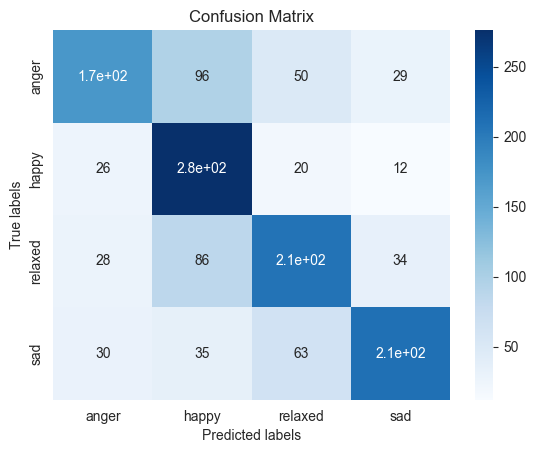

In [20]:
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

print("Accuracy: ", accuracy_score(y_true_labels, y_pred_labels))
print(classification_report(y_true_labels, y_pred_labels, target_names=le.classes_))

confusion_matrix = confusion_matrix(y_true_labels, y_pred_labels)
ax = plt.subplot()
sns.heatmap(confusion_matrix, annot=True, cmap='Blues')
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(le.classes_)
ax.yaxis.set_ticklabels(le.classes_)

EfficientNetB7

In [38]:
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

base_model = EfficientNetB7(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # zamrażamy wstępnie

inputs = Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
outputs = Dense(y_cnn.shape[1], activation='softmax')(x)

model = Model(inputs, outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

258076736/258076736 ━━━━━━━━━━━━━━━━━━━━ 26s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb7 (Functional)     │ (None, 7, 7, 2560)     │    64,097,687 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2560)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2560)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4)              │        10,244 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 64,107,931 (244.55 MB)

 Trainable params: 10,244 (40.02 KB)

 Non-trainable params: 64,097,687 (244.51 MB)

In [39]:
model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[
        EarlyStopping(patience=5, restore_best_weights=True),
        ModelCheckpoint("effnetb7_audio_emotion.keras", save_best_only=True)
    ]
)

Epoch 1/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 816s 6s/step - accuracy: 0.3625 - loss: 1.3095 - val_accuracy: 0.4854 - val_loss: 1.1615
Epoch 2/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 742s 5s/step - accuracy: 0.4441 - loss: 1.2191 - val_accuracy: 0.4745 - val_loss: 1.1546
Epoch 3/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 743s 5s/step - accuracy: 0.4535 - loss: 1.1847 - val_accuracy: 0.4964 - val_loss: 1.1448
Epoch 4/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 754s 5s/step - accuracy: 0.4640 - loss: 1.1678 - val_accuracy: 0.5155 - val_loss: 1.1216
Epoch 5/50
  2/138 ━━━━━━━━━━━━━━━━━━━━ 8:53 4s/step - accuracy: 0.5234 - loss: 1.0999

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x000002027DD16340>>
Traceback (most recent call last):
  File "C:\Users\Gabi\PycharmProjects\Music-Emotion-Recognition\venv\lib\site-packages\ipykernel\ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


KeyboardInterrupt: 

Najlepiej sprawdził się model ResNet50 bez finetuningu i dodatkowej augmentacji danych z accuracy na poziomie 72%. Pokazuje to, że te dane mają potencjał i można stworzyć modele, które się ich nauczą. Kolejne kroki to na pewno jeszcze lepsze przygotowanie danych, preprocessing oraz odpowiednia augmentacja, dzięki czemu nowe lub transferowe modele mogą osiągać wyższe wyniki.